In [1]:
import sys
sys.path.append('../src')
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import erfinv
from sparse_coding_model import SparseCoding, normalize01
from utils import *
from train_funcs import load_models, generate_HVC
from sklearn.decomposition import DictionaryLearning
rng = np.random.default_rng()

In [2]:
fname = '../realistic_auditory_processing/learned_song_responses.npz'
T_SONG = np.load(fname)['ctrl'].shape[2] # (n_songs, N, T)

In [3]:
adult = dict(np.load('../adult_songs/data.npz'))
n_samples, n_syl, n_freq_bins, n_time_bins = adult['spec_syl'].shape
# xmin = adult['spec_syl'].min(axis=(0,2,3), keepdims=True) # syl-wise norm
# xmax = adult['spec_syl'].max(axis=(0,2,3), keepdims=True)
# adult['spec_syl'] = (adult['spec_syl'] - xmin) / (xmax - xmin)

In [4]:
n_basis = 20
basis = np.zeros((n_basis, n_freq_bins*n_time_bins))
coefs = np.zeros((n_samples*n_syl, n_basis))
dl = DictionaryLearning(n_components=n_basis, alpha=0.1, fit_algorithm='cd', 
                        positive_code=True, positive_dict=True)
aux = np.concatenate([adult['spec_syl'][:,i].reshape(n_samples, -1) 
                      for i in range(n_syl)])
coefs = dl.fit_transform(aux)
a_std = coefs.std(axis=0)[None,:]
coefs/= a_std
basis = dl.components_ * a_std.T

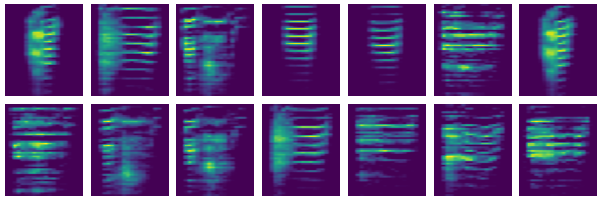

In [5]:
fig, ax = plt.subplots(2, 7, figsize=(6, 2))
ax = ax.flatten()
for i, b in enumerate(basis):
    if i >= len(ax):
        break
    ax[i].imshow(b.reshape(n_freq_bins, n_time_bins))
    ax[i].set_axis_off()

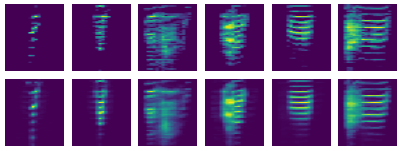

In [6]:
_ = coefs @ basis
fig, ax = plt.subplots(2, n_syl, figsize=(4, 1.5))
for i in range(n_syl):
    j = rng.integers(0,n_samples)
    ax[0,i].imshow(adult['spec_syl'][j,i])
    ax[1,i].imshow(_[i*n_samples+j].reshape(n_freq_bins, n_time_bins))
    ax[0,i].set_axis_off()
    ax[1,i].set_axis_off()

In [7]:
class Environment:
    VOCAL_ERR_NET_MAP = {'FF': 0, 'EI-HVC2E': 1, 'EI-E2E': 2, 'EI-E2I2E': 3}
    def __init__(self, action_basis, n_time_bins, T_song, 
                 dir_sensory_net, dir_vocal_error_net, vocal_error_net_type, 
                 T_burn=500, T_post=50, spec_dt=10,
                 HVC_peak_rate=150, HVC_kernel_width=20):
        # Constants
        self.T_song = T_song
        self.T_burn = T_burn
        self.T_post = T_post
        self.T = T_burn + T_song + T_post
        self.spec_dt = spec_dt
        
        # Store action basis
        # (n_basis, n_freq_bins*n_time_bins)
        self.action_basis = action_basis
        # self.action_basis = np.concatenate(action_basis, axis=0) 
        self.action_dim = self.action_basis.shape[0]
        
        # Load sensory net
        sensory_basis = torch.load(dir_sensory_net)
        assert sensory_basis.shape[0] % n_time_bins == 0
        self.n_sensory_basis = sensory_basis.shape[1]
        self.n_time_bins = n_time_bins
        self.n_freq_bins = sensory_basis.shape[0] // n_time_bins
        self.sensory = SparseCoding(n_basis=self.n_sensory_basis, 
                                    n_freq_bins=self.n_freq_bins, 
                                    n_time_bins=self.n_time_bins)
        self.sensory.basis = sensory_basis

        # Load vocal error net
        ret = load_models(dir_vocal_error_net, 'neighbor', 'EIIE', 'mature_hvc', 0)
        self.ve_net = ret[Environment.VOCAL_ERR_NET_MAP[vocal_error_net_type]]
        self.sensory_mapping = ret[-1]
        self.ve_net_in_dim, self.HVC_dim = self.ve_net.W.shape
        
        # Construct HVC firing
        burst_ts = np.linspace(T_burn, T_burn+T_song, num=self.HVC_dim, endpoint=False)
        aux = np.zeros((self.HVC_dim,1))
        self.rH = generate_HVC(T_burn+T_song+T_post, burst_ts[:,None], 
                               HVC_peak_rate+aux, HVC_kernel_width+aux)

        self.t0 = adult['syl_on'].mean(axis=0).astype(int)
        self.t1 = adult['syl_off'].mean(axis=0).astype(int)
        self._init_ve_net()

    def _init_ve_net(self):
        hE0 = rng.normal(loc=-10, scale=0.5, size=self.ve_net.NE)
        hI0 = rng.normal(loc=-1, scale=0.5, size=self.ve_net.NI)
        if not hasattr(self.ve_net, 'NI'):
            self.hI0 = -1
        
        rE, rI, _, hE, hI = self.ve_net.sim(hE0, hI0=hI0, rH=self.rH[:self.T_burn], 
                                            aud=np.zeros((self.T_burn, self.ve_net_in_dim)), 
                                            save_W_ts=[], T=self.T_burn, dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        self.hE0, self.hI0 = hE, hI
        
    
    def _perform(self, action):
        assert action.shape[0] == n_syl
        bos = action.numpy() @ self.action_basis
        bos = bos.reshape(-1, self.n_freq_bins, self.n_time_bins).clip(min=0)
        emb = np.zeros((bos.shape[0], self.sensory_mapping.shape[-1]))
        i_active = np.where(bos.mean(axis=(1,2)) > 1e-3)[0]

        if len(i_active) > 0:
            aux = self.sensory(torch.tensor(bos[i_active], dtype=torch.float32), 
                               n_iter_coef=200)
            emb[i_active] = aux[...,0].numpy() @ self.sensory_mapping
            if np.isnan(emb).any():
                plt.imshow(bos)
        return bos, emb

    def _reward(self, song, h0s=None):
        rE, rI, _, hE, hI = self.ve_net.sim(self.hE0, hI0=self.hI0, rH=self.rH[self.T_burn:], 
                                            aud=song, save_W_ts=[], T=self.T-self.T_burn, dt=1, 
                                            noise_strength=0, no_progress_bar=True)
        
        return -rE.mean(axis=1)
        
    def step(self, action):
        song_emb = np.zeros((self.T-self.T_burn, self.ve_net_in_dim))
        bos, emb = self._perform(action)
        for i in range(n_syl):
            song_emb[self.t0[i]:self.t0[i]+100] = emb[None,i,:]
        r = self._reward(song_emb)
        return bos, song_emb, r

In [8]:
from torch.distributions import Bernoulli, Normal
import torch.nn.functional as F

class ActorCritic(nn.Module):
    def __init__(self, n_out):
        super(ActorCritic, self).__init__()
        self.critic = nn.Parameter(torch.ones(n_syl, dtype=torch.float))
        self.actor_prob = nn.Parameter(torch.ones(n_syl, n_out, dtype=torch.float))
    
    def forward(self):
        val = self.critic
        action_dist = Bernoulli(F.softmax(self.actor_prob, dim=-2))
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action).sum(axis=1) # (n_syl,)
        entropy = action_dist.entropy().mean()
        return action, val, log_prob, entropy

    def l1(self, coef):
        return torch.abs(self.actor_prob).mean() * coef

In [9]:
env = Environment(basis, n_time_bins, T_SONG,
                  '../realistic_auditory_processing/net_params.pkl', 
                  '../results/', 'EI-E2I2E')

In [10]:
agent = ActorCritic(env.action_dim)

optimizer = torch.optim.Adam(agent.parameters(), lr=3e-1)

In [11]:
actor_losses, critic_losses = [], []
total_rewards, advantages, ve_rates = [], [], []
actions, songs, song_embs = [], [], []

batch = 20

for epoch in tqdm(range(6000)):
    if epoch % batch == 0:
        actor_loss, critic_loss = 0, 0
        optimizer.zero_grad()
    
    action, val, log_prob, entropy = agent()
    bos, song_emb, rE = env.step(action)
    
    if epoch == 0 or (epoch+1) % 100 == 0:
        songs.append(bos)
        song_embs.append(song_emb)
        ve_rates.append(rE.copy())

    # baseline subtraction; the rE here also includes the burning period from 0 to T_burn
    rewards = [rE[env.t0[t]:env.t0[t]+120].mean() for t in range(n_syl)]
    rewards = np.array(rewards) * 10 + 20
    total_rewards.append(np.mean(rewards))

    advantage = torch.tensor(rewards) - val
    critic_loss += (advantage**2).sum()
    actor_loss += -(log_prob * advantage.detach()).sum()

    if (epoch+1) % batch == 0:
        actor_losses.append(actor_loss.item())
        critic_losses.append(critic_loss.item())
        entropy_weight = 0.1
        l1 = agent.l1(1)
        loss = actor_loss + critic_loss - entropy * entropy_weight + l1
        loss.backward()
        optimizer.step()
    
    advantages.append(advantage.detach().sum())

100%|███████████████████████████████████████| 6000/6000 [23:25<00:00,  4.27it/s]


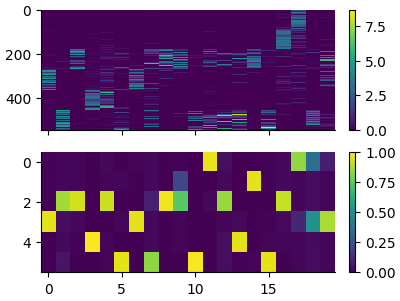

In [12]:
fig, ax = plt.subplots(2, figsize=(4,3), sharex='all')
im = ax[0].imshow(coefs, interpolation='none')
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(F.softmax(agent.actor_prob.data, dim=-2), vmin=0, vmax=1)
plt.colorbar(im, ax=ax[1])

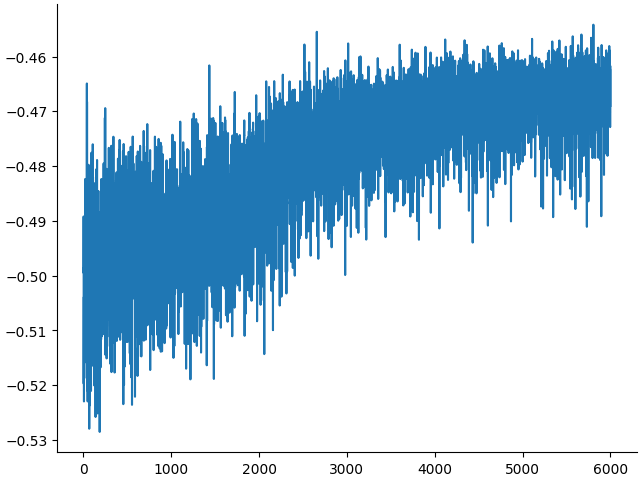

In [13]:
plt.plot(total_rewards)

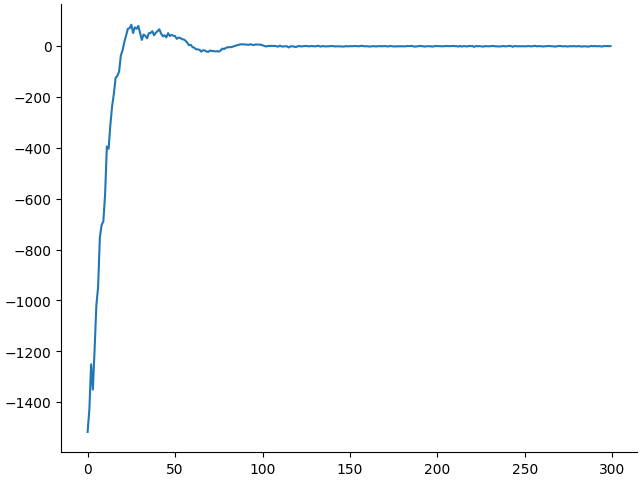

In [14]:
plt.plot(actor_losses)

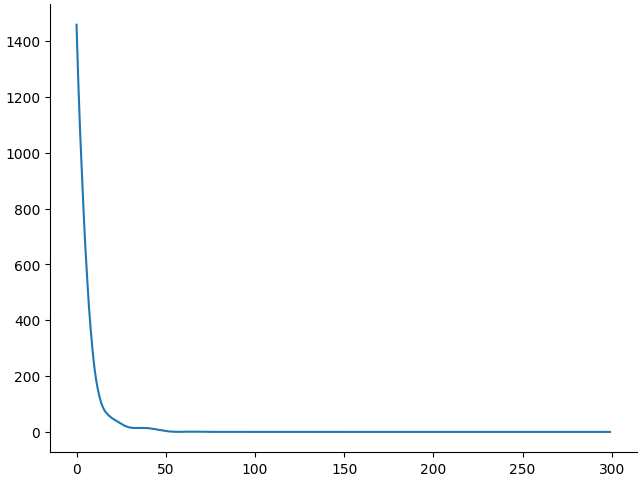

In [15]:
plt.plot(critic_losses)

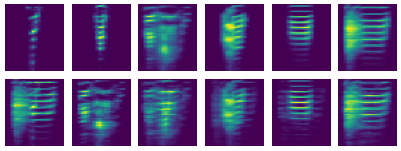

In [16]:
fig, ax = plt.subplots(2, n_syl, figsize=(4, 1.5))
for i in range(n_syl):
    ax[0,i].imshow(adult['spec_syl'][:,i].mean(axis=0))
    ax[1,i].imshow(songs[-1][i])
    ax[0,i].set_axis_off()
    ax[1,i].set_axis_off()

In [17]:
assert False

AssertionError: 

In [ ]:
torch.save(agent.state_dict(), 'params.pt')

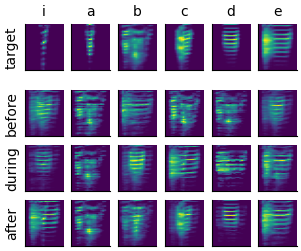

In [18]:
fig, ax = plt.subplots(4, n_syl, figsize=(3, 2.5))
for i, t in enumerate('iabcde'):
    ax[0,i].imshow(adult['spec_syl'][:,i].mean(axis=0))
    ax[1,i].imshow(songs[0][i])
    ax[2,i].imshow(songs[10][i])
    ax[3,i].imshow(songs[-1][i])
    for k in range(4):
        ax[k,i].set(xticks=[], yticks=[])
    ax[0,i].set_title(t)#, weight='bold' if i > 1 else 'normal')
ax[1,0].set_title(' ', fontsize=3)
for i, y in enumerate(('target', 'before', 'during', 'after')):
    ax[i,0].set(ylabel=y)
fig.savefig('../svg/rl_results.svg')

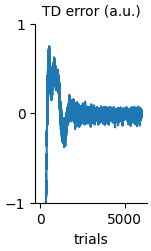

In [19]:
fig, ax = plt.subplots(1, figsize=(1.5,2.5))
ax.plot(advantages)
ax.set(title='TD error (a.u.)', xlabel='trials', ylim=[-1, 1], yticks=[-1, 0, 1])
fig.savefig('../svg/rl_mean_err.svg')